In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#συνδέση του Google Drive στο Colab
# Χρησιμοποιείται για να διαβάζουμε/γράφουμε αρχεία απευθείας από το Drive
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Mounted at /content/drive


CLASSIFICATION - ΤΑΞΙΝΟΜΗΣΗ

In [2]:
# CLASSIFICATION (Daily-level)
# Στόχος: να δημιουργήσουμε ένα ημερήσιο dataset (1 γραμμή = 1 ημέρα)
# πάνω στο οποίο θα κάνουμε δυαδική ταξινόμηση:
# 0 = normal/low κατανάλωση, 1 = high/anomalous κατανάλωση.
# Εργαζόμαστε σε daily επίπεδο για να ταιριάζει με τα ζητούμενα της εργασίας
# και να μειώσουμε τον θόρυβο των minute-level μετρήσεων.
TIME_COL = "timestamp"

# Φόρτωση αρχικού dataset (messy μορφή):
# - separator ';' όπως δίνεται από UCI
# - το '?' δηλώνει missing values και μετατρέπεται σε NaN για σωστό cleaning
df = pd.read_csv(
    '/content/drive/MyDrive/Datamining_Project/household_power_consumption.txt',
    sep=';',
    na_values=['?']
)

# Μετατρέπουμε Date+Time σε ενιαίο timestamp.
# errors="coerce": οποιαδήποτε προβληματική τιμή γίνεται NaT και αφαιρείται,
# ώστε να αποφύγουμε χρονικές ασυνέπειες που χαλάνε τα time-based βήματα.
df[TIME_COL] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors="coerce")
df = df.drop(columns=['Date', 'Time'])
df = df.dropna(subset=[TIME_COL])

# Global_active_power: ισχύς (kW) ανά λεπτό.
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

# Μετατροπή από kW (ισχύς ανά λεπτό) -> kWh ανά λεπτό διαιρώντας με 60,
# ώστε το ημερήσιο άθροισμα να δίνει συνολική ημερήσια κατανάλωση (kWh).
df["kWh"] = df["Global_active_power"] / 60.0

# Daily aggregation: Ομαδοποιούμε ανά ημέρα και αθροίζουμε την ενέργεια (kWh) ανά λεπτό -> 1 γραμμή/ημέρα,
df["date"] = df[TIME_COL].dt.floor("D")
daily = (
    df.groupby("date", as_index=False)["kWh"].sum()
      .rename(columns={"kWh": "Daily_total_kWh"})
)

# Χρονικά features:
# - day_of_week: εβδομαδιακό μοτίβο
# - month: εποχικότητα
# - day_of_month: πιθανές μηνιαίες συνήθειες
# - is_weekend: δυαδικό feature για Σάββατο/Κυριακή
daily["day_of_week"] = daily["date"].dt.dayofweek.astype("int64")
daily["month"] = daily["date"].dt.month.astype("int64")
daily["day_of_month"] = daily["date"].dt.day.astype("int64")
# Weekend feature
daily["is_weekend"] = (daily["day_of_week"] >= 5).astype(int)


# Lag/Rolling features (μόνο από παρελθόν -> no leakage):
# ΔΕΝ χρησιμοποιεί την ίδια μέρα, άρα αποφεύγεται leakage
daily = daily.sort_values("date").reset_index(drop=True)
# - lag1: εξάρτηση από χθεσινή κατανάλωση
daily["lag1_kWh"] = daily["Daily_total_kWh"].shift(1)
# - lag7: εβδομαδιακή περιοδικότητα
daily["lag7_kWh"] = daily["Daily_total_kWh"].shift(7)
# - roll7_mean με shift(1): μέσος όρος των προηγούμενων 7 ημερών
daily["roll7_mean_kWh"] = daily["Daily_total_kWh"].shift(1).rolling(7).mean()

daily = daily.dropna().reset_index(drop=True)

daily.head()


,date,Daily_total_kWh,day_of_week,month,day_of_month,is_weekend,lag1_kWh,lag7_kWh,roll7_mean_kWh
0,2006-12-23,79.556433,5,12,23,1,39.022300,20.152933,35.127062
1,2006-12-24,42.500200,6,12,24,1,79.556433,56.507667,43.613276
2,2006-12-25,45.718667,0,12,25,0,42.500200,36.730433,41.612210
3,2006-12-26,65.568500,1,12,26,0,45.718667,27.769900,42.896243
4,2006-12-27,25.479333,2,12,27,0,65.568500,37.095800,48.296043


In [3]:
# Χρονολογικό split (όχι random ->  80% train, 20% test):
split_ratio = 0.8
n = len(daily)
split_idx = int(np.floor(n * split_ratio))

# Το training περιέχει παλαιότερες ημέρες και το test νεότερες,
# ώστε η αξιολόγηση να προσομοιώνει πραγματική πρόβλεψη στο μέλλον.
train_df = daily.iloc[:split_idx].copy()
test_df  = daily.iloc[split_idx:].copy()

train_df.shape, test_df.shape


((1148, 9), (287, 9))

In [4]:
# Ορισμός ετικέτας "High" ΜΟΝΟ από train mean (χωρίς leakage)
train_mean_kwh = train_df["Daily_total_kWh"].mean()

train_df["High_consumption"] = (train_df["Daily_total_kWh"] > train_mean_kwh).astype(int)
test_df["High_consumption"]  = (test_df["Daily_total_kWh"] > train_mean_kwh).astype(int)

train_mean_kwh, train_df["High_consumption"].mean(), test_df["High_consumption"].mean()


(np.float64(26.45288342044135),
 np.float64(0.4878048780487805),
 np.float64(0.3623693379790941))

In [5]:
# Feature matrix X / target y
feature_cols = [
    "day_of_week", "month", "day_of_month",
    "is_weekend",
    "lag1_kWh", "lag7_kWh", "roll7_mean_kWh"

]

X_train = train_df[feature_cols].copy()

X_test = test_df[feature_cols].copy()

y_train_cont = train_df["Daily_total_kWh"].copy()
y_test_cont  = test_df["Daily_total_kWh"].copy()

# Ορίζουμε ετικέτα "High" με quantile threshold (75ο εκατοστημόριο).
# Πολύ σημαντικό: το threshold υπολογίζεται ΜΟΝΟ στο TRAIN set
# ώστε να αποφύγουμε leakage από το test set.
threshold = y_train_cont.quantile(0.75)

y_train = (y_train_cont > threshold).astype(int)
y_test  = (y_test_cont  > threshold).astype(int)

X_train.head()

,day_of_week,month,day_of_month,is_weekend,lag1_kWh,lag7_kWh,roll7_mean_kWh
0,5,12,23,1,39.022300,20.152933,35.127062
1,6,12,24,1,79.556433,56.507667,43.613276
2,0,12,25,0,42.500200,36.730433,41.612210
3,1,12,26,0,45.718667,27.769900,42.896243
4,2,12,27,0,65.568500,37.095800,48.296043


In [6]:
# Ενδεικτική εμφάνιση ετικετών (0/1) για μερικές ημέρες
label_preview = test_df.assign(
    y_true=y_test.values
)[["date", "Daily_total_kWh", "y_true"]].head(10)

label_preview


,date,Daily_total_kWh,y_true
1148,2010-02-13,39.192600,1
1149,2010-02-14,28.111633,0
1150,2010-02-15,34.952200,1
1151,2010-02-16,29.962600,0
1152,2010-02-17,34.242667,1
1153,2010-02-18,29.352600,0
1154,2010-02-19,32.559533,1
1155,2010-02-20,33.062133,1
1156,2010-02-21,45.671900,1
1157,2010-02-22,24.567267,0


In [7]:
# Summary table για τη μεταβλητή στόχο (0/1)
summary_table = pd.DataFrame({
    "Class (y)": [0, 1],
    "Meaning": [
        "Low / Normal consumption (≤ train mean)",
        "High consumption (> train mean)"
    ],
    "Train samples": [
        (y_train == 0).sum(),
        (y_train == 1).sum()
    ],
    "Test samples": [
        (y_test == 0).sum(),
        (y_test == 1).sum()
    ]
})

summary_table


,Class (y),Meaning,Train samples,Test samples
0,0,Low / Normal consumption (≤ train mean),861,254
1,1,High consumption (> train mean),287,33


In [8]:
# Preprocessing - Διαχωρισμός features:
# - categorical: day_of_week (θα γίνει one-hot)
# - numeric: όλα τα υπόλοιπα (impute + scale)
categorical_features = ["day_of_week"]
numeric_features = [c for c in feature_cols if c not in categorical_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer:
# Εφαρμόζει διαφορετικό preprocessing ανά τύπο feature
# και εξασφαλίζει ότι τα transformations γίνονται σωστά μέσα στο Pipeline -> απαραίτητο για σωστό CV χωρίς leakage.
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


In [9]:
# Μοντέλα προς σύγκριση
models = {
    # Logistic Regression: baseline γραμμικό μοντέλο (με class_weight για imbalance)
    "LogReg (balanced)": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ),
    # Random Forest: μη γραμμικό ensemble (robust σε θόρυβο)
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample"
    ),
    # Gradient Boosting: boosting προσέγγιση για πιο σύνθετα patterns
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42
    ),
}


In [10]:
# Χρησιμοποιούμε TimeSeriesSplit ώστε κάθε validation fold
# να περιέχει "μελλοντικά" δείγματα σε σχέση με το αντίστοιχο train fold.
def evaluate_model_ts_cv(name, model, X_tr, y_tr, X_te, y_te, preprocess, n_splits=5):
    # Pipeline
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    tscv = TimeSeriesSplit(n_splits=n_splits)
    # Μετρικές:
    # Accuracy: γενική επίδοση
    # F1: ισορροπία precision/recall
    # ROC-AUC: ικανότητα διαχωρισμού ανεξάρτητα από threshold
    cv_acc, cv_f1, cv_auc = [], [], []

    for train_idx, val_idx in tscv.split(X_tr):
        X_train_fold, X_val_fold = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
        y_train_fold, y_val_fold = y_tr.iloc[train_idx], y_tr.iloc[val_idx]

        pipe.fit(X_train_fold, y_train_fold)

        # προβλέψεις
        y_pred = pipe.predict(X_val_fold)

        # πιθανότητες για AUC (αν δεν υπάρχουν, δοκιμάζουμε decision_function)
        if hasattr(pipe, "predict_proba"):
            y_score = pipe.predict_proba(X_val_fold)[:, 1]
        elif hasattr(pipe, "decision_function"):
            # μετατροπή σε [0,1] με logistic για σταθερότητα
            scores = pipe.decision_function(X_val_fold)
            y_score = 1 / (1 + np.exp(-scores))
        else:
            y_score = None

        cv_acc.append(accuracy_score(y_val_fold, y_pred))
        cv_f1.append(f1_score(y_val_fold, y_pred))

        if y_score is not None and len(np.unique(y_val_fold)) > 1:
            cv_auc.append(roc_auc_score(y_val_fold, y_score))

    # fit στο full train
    pipe.fit(X_tr, y_tr)

    # test eval
    y_pred_test = pipe.predict(X_te)
    if hasattr(pipe, "predict_proba"):
        y_score_test = pipe.predict_proba(X_te)[:, 1]
    elif hasattr(pipe, "decision_function"):
        scores = pipe.decision_function(X_te)
        y_score_test = 1 / (1 + np.exp(-scores))
    else:
        y_score_test = None

    test_acc = accuracy_score(y_te, y_pred_test)
    test_f1 = f1_score(y_te, y_pred_test)
    test_auc = roc_auc_score(y_te, y_score_test) if (y_score_test is not None and len(np.unique(y_te)) > 1) else np.nan

    results = {
        "model": name,
        "cv_acc_mean": float(np.mean(cv_acc)),
        "cv_f1_mean": float(np.mean(cv_f1)),
        "cv_auc_mean": float(np.mean(cv_auc)) if len(cv_auc) else np.nan,
        "test_acc": float(test_acc),
        "test_f1": float(test_f1),
        "test_auc": float(test_auc),
        "pipeline": pipe,  # κρατάμε το fitted pipeline
        "y_pred_test": y_pred_test,
        "y_score_test": y_score_test
    }
    return results

all_results = []
for name, model in models.items():
    res = evaluate_model_ts_cv(
        name, model,
        X_train, y_train,
        X_test, y_test,
        preprocess=preprocess,
        n_splits=5
    )
    all_results.append(res)

results_df = pd.DataFrame([{
    k: v for k, v in r.items()
    if k not in ["pipeline", "y_pred_test", "y_score_test"]
} for r in all_results]).sort_values("test_auc", ascending=False)

results_df


,model,cv_acc_mean,cv_f1_mean,cv_auc_mean,test_acc,test_f1,test_auc
1,RandomForest,0.792670,0.507310,0.832633,0.881533,0.413793,0.818599
2,GradientBoosting,0.785340,0.515080,0.823847,0.871080,0.327273,0.803985
0,LogReg (balanced),0.747644,0.548206,0.809406,0.790941,0.400000,0.745168


In [11]:
# Διάλεξε best model (με βάση test_auc) και δείξε metrics + confusion matrix
best_idx = results_df.index[0]
best_name = results_df.loc[best_idx, "model"]

best_res = next(r for r in all_results if r["model"] == best_name)
best_pipe = best_res["pipeline"]
y_pred = best_res["y_pred_test"]
y_score = best_res["y_score_test"]

print("BEST MODEL:", best_name)
print("\nClassification report (TEST):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)


BEST MODEL: RandomForest

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9198    0.9488    0.9341       254
           1     0.4800    0.3636    0.4138        33

    accuracy                         0.8815       287
   macro avg     0.6999    0.6562    0.6740       287
weighted avg     0.8693    0.8815    0.8743       287

Confusion matrix (rows=true, cols=pred):
 [[241  13]
 [ 21  12]]


<Figure size 700x500 with 0 Axes>

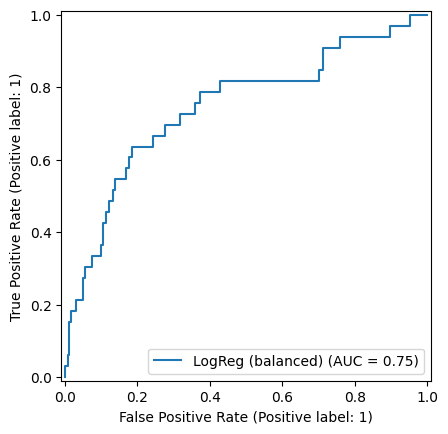

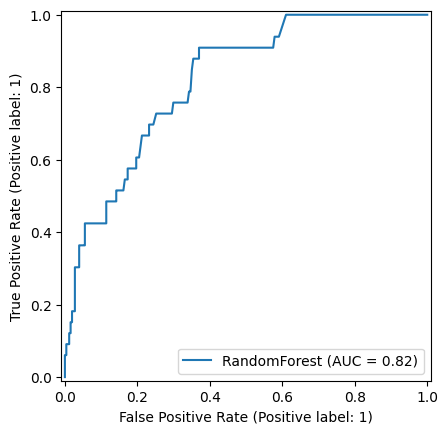

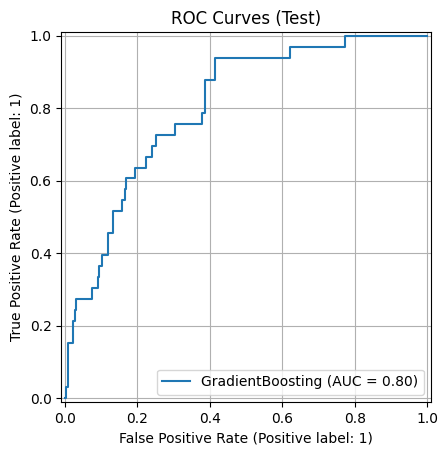

In [12]:
# ROC curves στο TEST:
# Οπτική σύγκριση των μοντέλων ως προς την ικανότητα διάκρισης της κλάσης 1 (High).
plt.figure(figsize=(7, 5))
for r in all_results:
    if r["y_score_test"] is None:
        continue
    RocCurveDisplay.from_predictions(
        y_test, r["y_score_test"],
        name=r["model"]
    )
plt.title("ROC Curves (Test)")
plt.grid(True)
plt.show()


REGRESSION - ΠΑΛΙΝΔΡΟΜΗΣΗ

In [13]:
#Φορτώνουμε το dataset που φτιαξαμε στο κοινό notebook processing.ipynb
daily = pd.read_parquet(
    "/content/drive/MyDrive/Datamining_Project/power_daily_features.parquet"
)
# Αν το index είναι ημερομηνία
daily = daily.sort_index()
# Γρήγορος έλεγχος ότι φορτώθηκαν σωστά τα δεδομένα
daily.head()

,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend,Nighttime_kWh,Peak_hour_power,Weekend_kWh,season
Datetime,,,,,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1,NaN,4.222889,20.152933,Winter
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1,12.693833,3.697100,56.507667,Winter
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0,2.503900,3.050567,0.000000,Winter
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0,2.460200,3.879033,0.000000,Winter
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0,2.364600,3.646067,0.000000,Winter


In [14]:
# Regression – Πρόβλεψη Επόμενης ημέρας
# Features
features_num = [
    "Nighttime_kWh",
    "Peak_hour_power",
    "day_of_week",
    "is_weekend"
]
features_cat = ["season"]

# Sort
daily = daily.sort_index()

# Ορισμός στόχου για regression:
# Daily_total_kWh_next = κατανάλωση της επόμενης ημέρας.
# shift(-1): μεταφέρει το target "μπροστά" στο χρόνο, ώστε τα features να είναι της ημέρας t.
daily["Daily_total_kWh_next"] = daily["Daily_total_kWh"].shift(-1)
daily_reg = daily.dropna(subset=["Daily_total_kWh_next"]).copy()

X_reg = daily_reg[features_num + features_cat]
y_reg = daily_reg["Daily_total_kWh_next"]

# Time-based split
split_idx = int(len(daily_reg) * 0.8)
Xr_train = X_reg.iloc[:split_idx].copy()
Xr_test  = X_reg.iloc[split_idx:].copy()
yr_train = y_reg.iloc[:split_idx].copy()
yr_test  = y_reg.iloc[split_idx:].copy()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy='median')),
            ("scaler", StandardScaler())
        ]), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
    ]
)

# Baseline: Linear Regression
lin_reg = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", LinearRegression())
])

lin_reg.fit(Xr_train, yr_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

yr_pred = lin_reg.predict(Xr_test)
# Regression metrics:
# MAE: μέσο απόλυτο σφάλμα (εύκολο στην ερμηνεία)
# RMSE: τιμωρεί έντονα τα μεγάλα λάθη
# R2: ποσοστό διακύμανσης που εξηγεί το μοντέλο
mae = mean_absolute_error(yr_test, yr_pred)
rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
r2 = r2_score(yr_test, yr_pred)

print("Linear Regression:", mae, rmse, r2)

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_reg = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

rf_reg.fit(Xr_train, yr_train)

yr_pred_rf = rf_reg.predict(Xr_test)
mae_rf = mean_absolute_error(yr_test, yr_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(yr_test, yr_pred_rf))
r2_rf = r2_score(yr_test, yr_pred_rf)

print("Random Forest:", mae_rf, rmse_rf, r2_rf)

reg_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae, mae_rf],
    "RMSE": [rmse, rmse_rf],
    "R2": [r2, r2_rf]
})

reg_results


Linear Regression: 4.888039972213437 6.390366682976692 0.2799714744793147
Random Forest: 4.99572120838776 6.593086417680795 0.23356437906398386


,Model,MAE,RMSE,R2
0,Linear Regression,4.888040,6.390367,0.279971
1,Random Forest,4.995721,6.593086,0.233564


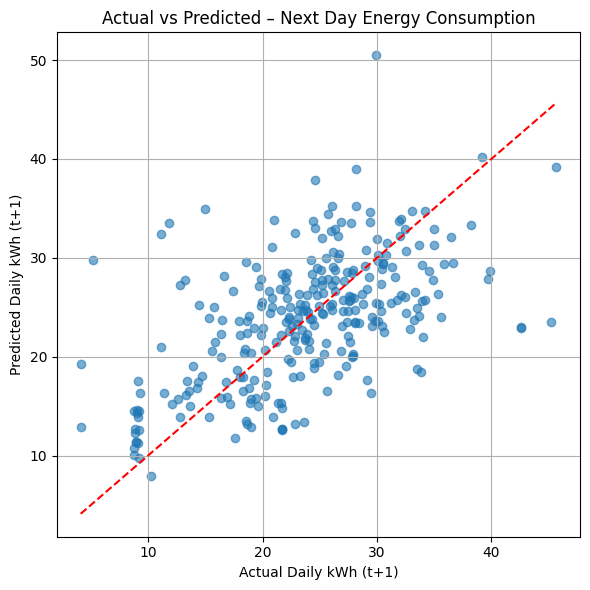

In [15]:
plt.figure(figsize=(6, 6))

plt.scatter(
    yr_test,
    yr_pred_rf,
    alpha=0.6
)

# Ιδανική γραμμή y = x
plt.plot(
    [yr_test.min(), yr_test.max()],
    [yr_test.min(), yr_test.max()],
    linestyle="--",
    color="red"
)

plt.xlabel("Actual Daily kWh (t+1)")
plt.ylabel("Predicted Daily kWh (t+1)")
plt.title("Actual vs Predicted – Next Day Energy Consumption")

plt.grid(True)
plt.tight_layout()
plt.show()


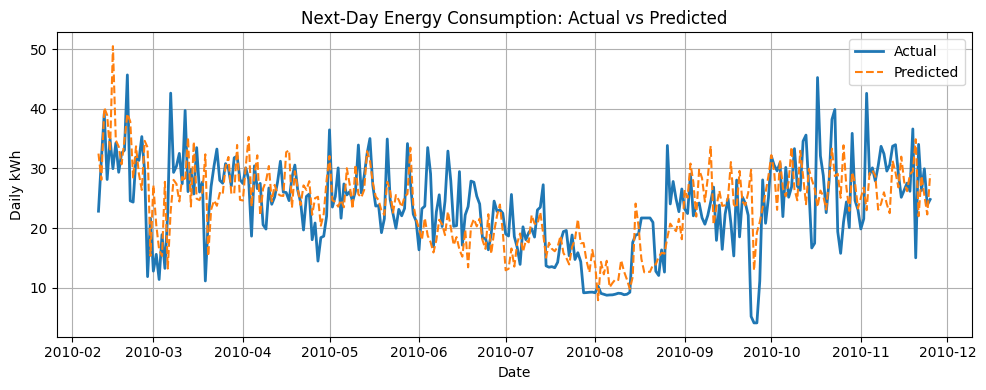

In [16]:
plt.figure(figsize=(10, 4))

plt.plot(
    yr_test.index,
    yr_test.values,
    label="Actual",
    linewidth=2
)

plt.plot(
    yr_test.index,
    yr_pred_rf,
    label="Predicted",
    linestyle="--"
)

plt.xlabel("Date")
plt.ylabel("Daily kWh")
plt.title("Next-Day Energy Consumption: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


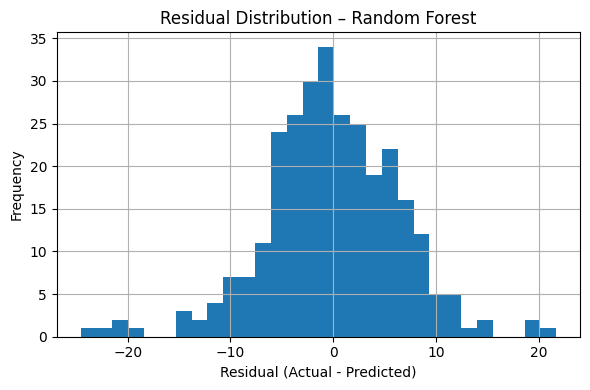

In [17]:
residuals = yr_test - yr_pred_rf

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()


CLUSTERING - ΟΜΑΔΟΠΟΙΗΣΗ

In [18]:
# Clustering: ομαδοποιούμε ημέρες σε "προφίλ κατανάλωσης".
# Επιλέγουμε 3 ερμηνεύσιμα features (total, night, peak)
features_for_clustering = ['Daily_total_kWh', 'Nighttime_kWh', 'Peak_hour_power']
X = daily[features_for_clustering]

# Handle missing values χρησιμοποιωντας SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Κανονικοποίηση (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("Τα δεδομένα είναι έτοιμα για ομαδοποίηση.")

Τα δεδομένα είναι έτοιμα για ομαδοποίηση.


    silhouette  davies_bouldin    inertia
k                                        
2       0.3853          1.0549  2684.6572
3       0.3904          0.8504  1738.6010
4       0.3693          0.8502  1285.3780
5       0.3827          0.8139  1067.9840
6       0.3374          0.8692   882.3524
7       0.2922          0.9763   789.1519
8       0.2968          0.9804   724.3940
9       0.3020          0.9635   666.5135
10      0.2980          0.9556   615.9878


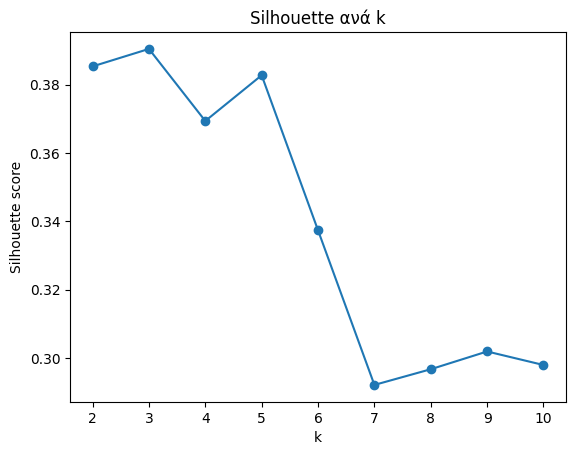

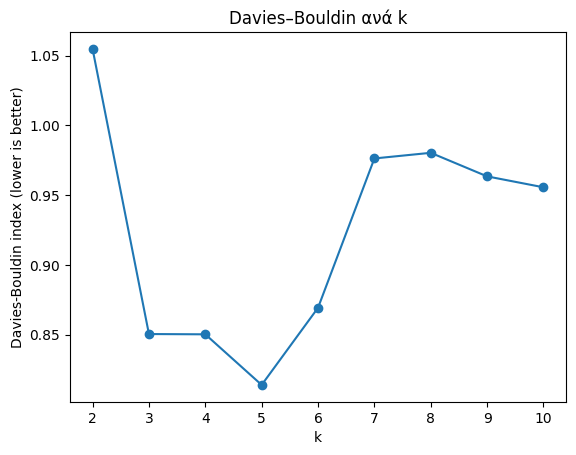

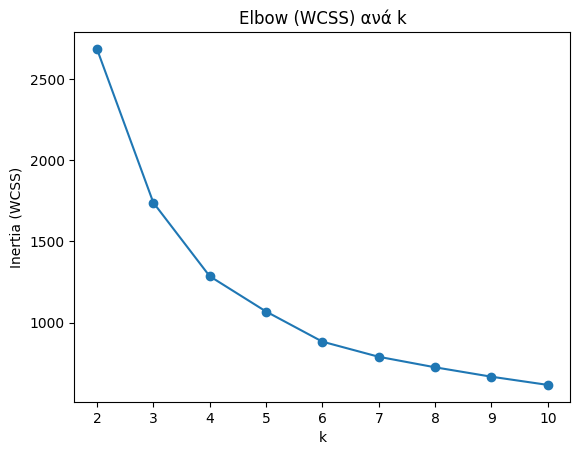

Best k by Silhouette: 3
Best k by trade-off (Silhouette+DBI ranks): 3


,silhouette,davies_bouldin,inertia,rank_sum
k,,,,
3,0.3904,0.8504,1738.6010,4.0
5,0.3827,0.8139,1067.9840,4.0
4,0.3693,0.8502,1285.3780,6.0
6,0.3374,0.8692,882.3524,9.0
2,0.3853,1.0549,2684.6572,11.0
9,0.3020,0.9635,666.5135,12.0
10,0.2980,0.9556,615.9878,12.0
7,0.2922,0.9763,789.1519,16.0
8,0.2968,0.9804,724.3940,16.0


In [19]:
k_values = range(2, 11)
rows = []
# Δοκιμάζουμε πολλά k και κρατάμε μετρικές: Silhouette, Davies-Bouldin & Inertia/Elbow
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    inertia = kmeans.inertia_  # WCSS

    rows.append({"k": k, "silhouette": sil, "davies_bouldin": dbi, "inertia": inertia})

metrics_df = pd.DataFrame(rows).set_index("k")
print(metrics_df.round(4))

# Plot Silhouette & DBI και inertia/elbow)
plt.figure()
plt.plot(metrics_df.index, metrics_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette ανά k")
plt.show()

plt.figure()
plt.plot(metrics_df.index, metrics_df["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin index (lower is better)")
plt.title("Davies–Bouldin ανά k")
plt.show()

plt.figure()
plt.plot(metrics_df.index, metrics_df["inertia"], marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow (WCSS) ανά k")
plt.show()

# Αυτόματη “πρόταση k”
# (A) Με μέγιστο Silhouette
best_k_sil = metrics_df["silhouette"].idxmax()

# Trade-off: υψηλό silhouette ΚΑΙ χαμηλό DBI
rank_sil = metrics_df["silhouette"].rank(ascending=False)   # 1=καλύτερο
rank_dbi = metrics_df["davies_bouldin"].rank(ascending=True) # 1=καλύτερο
metrics_df["rank_sum"] = rank_sil + rank_dbi
best_k_tradeoff = metrics_df["rank_sum"].idxmin()

print(f"Best k by Silhouette: {best_k_sil}")
print(f"Best k by trade-off (Silhouette+DBI ranks): {best_k_tradeoff}")
display(metrics_df.sort_values("rank_sum").round(4))


In [20]:
# Ορίζουμε τον αριθμό των clusters
n_clusters = best_k_tradeoff
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Sanity check: σταθερότητα KMeans σε διαφορετικά seeds
seeds = [0, 42, 123]
rows = []

for seed in seeds:
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        random_state=seed,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)

    rows.append({
        "random_state": seed,
        "silhouette": sil,
        "davies_bouldin": dbi
    })

stability_df = pd.DataFrame(rows)
print("Sanity check σταθερότητας KMeans:")
display(stability_df.round(4))


# Προσθήκη των clusters στο αρχικό DataFrame
daily['Cluster'] = clusters


daily['Cluster'].value_counts()

# Υπολογισμός Μετρικών Αξιολόγησης
sil_score = silhouette_score(X_scaled, clusters)
db_index = davies_bouldin_score(X_scaled, clusters)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

# Υπολογισμός μέσων όρων ανά συστάδα για ερμηνεία
cluster_analysis = daily.groupby('Cluster')[features_for_clustering].mean()
print("Μέσοι όροι ανά συστάδα:")
print(cluster_analysis)

pd.crosstab(
    daily['Cluster'],
    daily['is_weekend'],
    normalize='index'
)


Sanity check σταθερότητας KMeans:


,random_state,silhouette,davies_bouldin
0,0,0.3904,0.8500
1,42,0.3904,0.8504
2,123,0.3904,0.8506


Silhouette Score: 0.390
Davies-Bouldin Index: 0.850
Μέσοι όροι ανά συστάδα:
         Daily_total_kWh  Nighttime_kWh  Peak_hour_power
Cluster                                                 
0              18.448712       2.474244         2.035547
1              31.950591       2.742668         3.573820
2              41.442798      10.367448         3.661537


is_weekend,0,1
Cluster,,
0,0.792701,0.207299
1,0.671091,0.328909
2,0.405063,0.594937


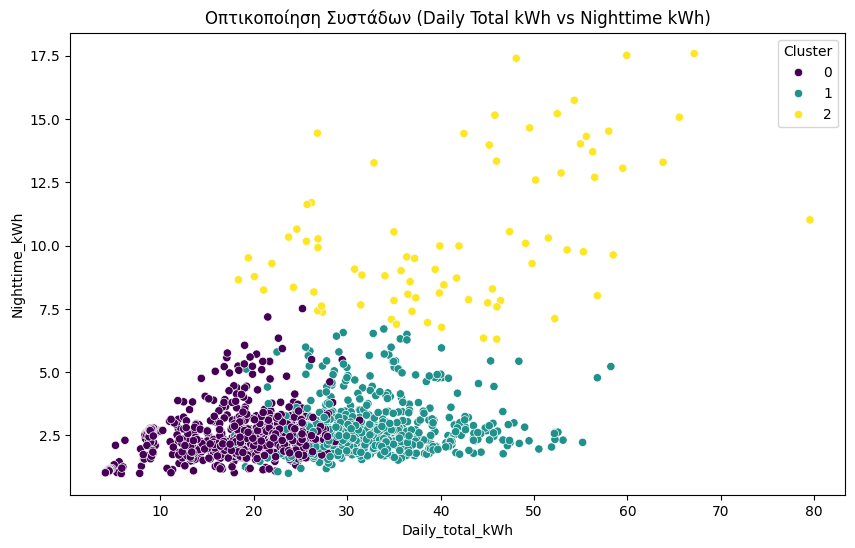

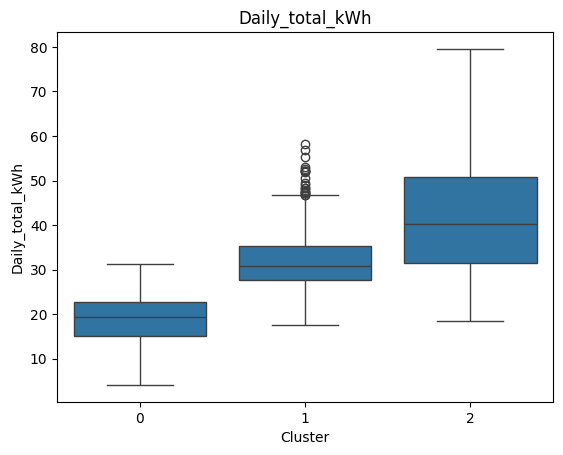

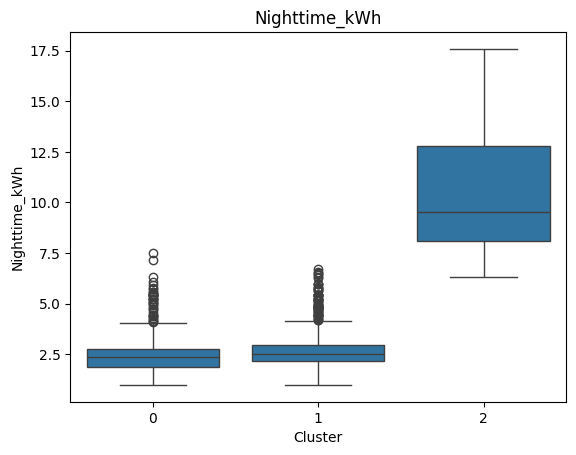

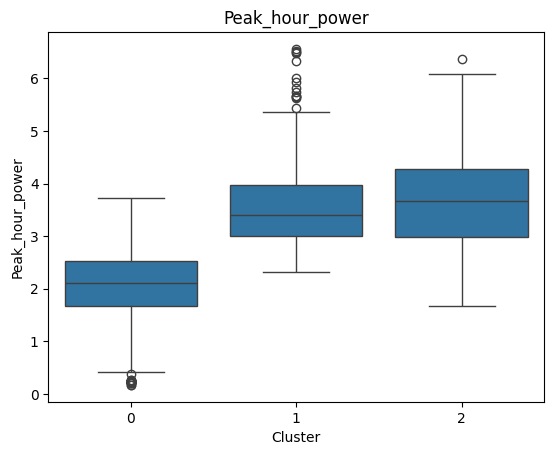

In [21]:
# Οπτικοποίηση των clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily, x='Daily_total_kWh', y='Nighttime_kWh', hue='Cluster', palette='viridis')
plt.title('Οπτικοποίηση Συστάδων (Daily Total kWh vs Nighttime kWh)')
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

features = ['Daily_total_kWh', 'Nighttime_kWh', 'Peak_hour_power']

for f in features:
    plt.figure()
    sns.boxplot(x='Cluster', y=f, data=daily)
    plt.title(f)
    plt.show()



Associations Rules - ΚΑΝΟΝΕΣ ΣΥΣΧΕΤΙΣΗΣ

In [22]:
#Association Rule Mining
#έλεγχος ύπαρξης πεδίων
print(daily.shape)
print(daily.columns)
daily.head()

(1442, 14)
Index(['Daily_total_kWh', 'Daily_Sub_metering_1_kWh',
       'Daily_Sub_metering_2_kWh', 'Daily_Sub_metering_3_kWh', 'Sub_sum_kWh',
       'day_of_week', 'day_name', 'is_weekend', 'Nighttime_kWh',
       'Peak_hour_power', 'Weekend_kWh', 'season', 'Daily_total_kWh_next',
       'Cluster'],
      dtype='object')


,Daily_total_kWh,Daily_Sub_metering_1_kWh,Daily_Sub_metering_2_kWh,Daily_Sub_metering_3_kWh,Sub_sum_kWh,day_of_week,day_name,is_weekend,Nighttime_kWh,Peak_hour_power,Weekend_kWh,season,Daily_total_kWh_next,Cluster
Datetime,,,,,,,,,,,,,,
2006-12-16,20.152933,0.000,0.546,4.926,5.472,5,Saturday,1,NaN,4.222889,20.152933,Winter,56.507667,1
2006-12-17,56.507667,2.033,4.187,13.341,19.561,6,Sunday,1,12.693833,3.697100,56.507667,Winter,36.730433,2
2006-12-18,36.730433,1.063,2.621,14.018,17.702,0,Monday,0,2.503900,3.050567,0.000000,Winter,27.769900,1
2006-12-19,27.769900,0.839,7.602,6.197,14.638,1,Tuesday,0,2.460200,3.879033,0.000000,Winter,37.095800,1
2006-12-20,37.095800,0.000,2.648,14.063,16.711,2,Wednesday,0,2.364600,3.646067,0.000000,Winter,28.618567,1


In [23]:
# Discretization για Association Rules

def discretize_3levels(series):
    return pd.qcut(series, q=3, labels=["Low", "Med", "High"], duplicates="drop")

daily_ar = daily.copy()

# Συνολική κατανάλωση (στόχος)
daily_ar["Total"] = discretize_3levels(daily_ar["Daily_total_kWh"])

# Νυχτερινή κατανάλωση
daily_ar["Night"] = discretize_3levels(daily_ar["Nighttime_kWh"])

# Peak hour
daily_ar["Peak"] = discretize_3levels(daily_ar["Peak_hour_power"])

# Σαββατοκύριακο
daily_ar["Weekend"] = np.where(daily_ar["is_weekend"] == 1, "Weekend", "Weekday")

# Sub-meterings (η “χρήση συσκευών”)
daily_ar["SM1"] = discretize_3levels(daily_ar["Daily_Sub_metering_1_kWh"])
daily_ar["SM2"] = discretize_3levels(daily_ar["Daily_Sub_metering_2_kWh"])
daily_ar["SM3"] = discretize_3levels(daily_ar["Daily_Sub_metering_3_kWh"])

daily_ar[["Total", "Night", "Peak", "Weekend","SM1", "SM2", "SM3"]].head()

,Total,Night,Peak,Weekend,SM1,SM2,SM3
Datetime,,,,,,,
2006-12-16,Low,NaN,High,Weekend,Low,Med,Low
2006-12-17,High,High,High,Weekend,High,High,High
2006-12-18,High,Med,Med,Weekday,Med,High,High
2006-12-19,Med,Med,High,Weekday,Low,High,Low
2006-12-20,High,Med,High,Weekday,Low,High,High


In [24]:
# Items που θα μπουν στις συναλλαγές
item_cols = ["Total", "Night", "Peak", "Weekend","SM1", "SM2", "SM3"]

# Διαγραφή NaN για να μη βγαίνει Night=nan
daily_ar = daily_ar.dropna(subset=item_cols).copy()

# Δημιουργία transactions (λίστες items) - Apriori
transactions = daily_ar[item_cols].astype(str).apply(
    lambda row: [f"{col}={row[col]}" for col in item_cols],
    axis=1
)

# Λεξικό "μετάφρασης"
pretty = {
    "Total=Low":  "Χαμηλή Συνολική Κατανάλωση",
    "Total=Med":  "Μέτρια Συνολική Κατανάλωση",
    "Total=High": "Υψηλή Συνολική Κατανάλωση",

    "Night=Low":  "Χαμηλή Νυχτερινή Χρήση",
    "Night=Med":  "Μέτρια Νυχτερινή Χρήση",
    "Night=High": "Υψηλή Νυχτερινή Χρήση",

    "Peak=Low":   "Χαμηλή Αιχμή",
    "Peak=Med":   "Μέτρια Αιχμή",
    "Peak=High":  "Υψηλή Αιχμή",

    "Weekend=Weekday": "Καθημερινή",
    "Weekend=Weekend": "Σαββατοκύριακο",

    "SM1=Low":"Χαμηλό Sub_metering_1", "SM1=Med":"Μέτριο Sub_metering_1", "SM1=High":"Υψηλό Sub_metering_1",
    "SM2=Low":"Χαμηλό Sub_metering_2", "SM2=Med":"Μέτριο Sub_metering_2", "SM2=High":"Υψηλό Sub_metering_2",
    "SM3=Low":"Χαμηλό Sub_metering_3", "SM3=Med":"Μέτριο Sub_metering_3", "SM3=High":"Υψηλό Sub_metering_3",
}

def pretty_tx(tx):
    return " + ".join(pretty.get(x, x) for x in tx)



In [25]:
# Μετατρέπουμε τις συναλλαγές σε πίνακα 0/1
# Κάθε στήλη αντιστοιχεί σε ένα item (π.χ. "Total=High") &  Κάθε γραμμή αντιστοιχεί σε μία ημέρα (συναλλαγή)
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# Δημιουργία DataFrame για ευκολότερη επεξεργασία
df_tx = pd.DataFrame(te_array, columns=te.columns_)
df_tx.head()


,Night=High,Night=Low,Night=Med,Peak=High,Peak=Low,Peak=Med,SM1=High,SM1=Low,SM1=Med,SM2=High,SM2=Low,SM2=Med,SM3=High,SM3=Low,SM3=Med,Total=High,Total=Low,Total=Med,Weekend=Weekday,Weekend=Weekend
0,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True
1,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False
2,False,False,True,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,True,False
3,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False
4,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,True,False


In [26]:
# Εφαρμογή Apriori για εντοπισμό συχνών συνδυασμών items
# min_support=0.10 -> το itemset εμφανίζεται τουλάχιστον στο 10% των ημερών
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    df_tx,
    min_support=0.10,
    use_colnames=True
)

# Ταξινόμηση κατά φθίνουσα υποστήριξη
frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)

frequent_itemsets.head(10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,support,itemsets
18,0.714781,(Weekend=Weekday)
10,0.335184,(SM2=Low)
6,0.333796,(SM1=High)
7,0.333796,(SM1=Low)
1,0.333796,(Night=Low)
4,0.333796,(Peak=Low)
14,0.333796,(SM3=Med)
15,0.333796,(Total=High)
2,0.333102,(Night=Med)
0,0.333102,(Night=High)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [27]:
# Εμφάνιση μόνο συνδυασμών με 2 ή περισσότερα items
frequent_itemsets[
    frequent_itemsets["itemsets"].apply(len) >= 2
].sort_values("support", ascending=False).head(10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,support,itemsets
100,0.276891,"(Weekend=Weekday, SM1=Med)"
111,0.274809,"(Weekend=Weekday, SM2=Low)"
81,0.269951,"(Weekend=Weekday, Peak=Med)"
93,0.265094,"(Weekend=Weekday, SM1=Low)"
126,0.261624,"(Weekend=Weekday, Total=Low)"
123,0.260236,"(Weekend=Weekday, SM3=Med)"
46,0.260236,"(Night=Low, Weekend=Weekday)"
73,0.256072,"(Weekend=Weekday, Peak=Low)"
59,0.254684,"(Weekend=Weekday, Night=Med)"
127,0.253296,"(Weekend=Weekday, Total=Med)"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Δημιουργία κανόνων συσχέτισης από τα συχνά itemsets
# metric="confidence" και min_threshold=0.6 -> κρατάμε κανόνες με τουλάχιστον 60% αξιοπιστία
from mlxtend.frequent_patterns import association_rules

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

# Ταξινόμηση ώστε πρώτα να εμφανίζονται οι πιο ισχυροί κανόνες
rules = rules.sort_values(
    ["lift", "confidence", "support"],
    ascending=False
)

rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,support,confidence,lift
70,"(SM1=Low, Total=Low)","(Peak=Low, SM3=Low)",0.140180,0.664474,3.395413
67,"(Peak=Low, SM3=Low)","(SM1=Low, Total=Low)",0.140180,0.716312,3.395413
137,"(SM3=High, Peak=High)","(SM2=High, Total=High)",0.111728,0.665289,3.317238
179,"(SM3=High, Peak=High)","(SM1=High, Total=High)",0.101319,0.603306,3.196190
69,"(SM1=Low, SM3=Low)","(Peak=Low, Total=Low)",0.140180,0.779923,3.174770
136,"(SM2=High, SM3=High)","(Peak=High, Total=High)",0.111728,0.759434,3.153730
189,"(SM2=Med, SM1=Low)","(Peak=Low, Total=Low)",0.100625,0.728643,2.966031
64,"(Peak=Low, SM3=Low, SM1=Low)",(Total=Low),0.140180,0.966507,2.901535
177,"(SM1=High, SM3=High, Peak=High)",(Total=High),0.101319,0.960526,2.877585
135,"(SM2=High, SM3=High, Peak=High)",(Total=High),0.111728,0.958333,2.871015


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


TIME SERIES FORECASTING- Πρόβλεψη Χρονοσειρών

In [29]:
#Time Series Forecasting
# Επιλέγουμε τη χρονοσειρά που θα προβλέψουμε
ts = daily["Daily_total_kWh"].copy()
ts = ts.asfreq("D")  # εξασφαλίζει daily frequency (αν έχεις κενά θα γίνουν NaN)
ts = ts.interpolate("time")  # γεμίζει μικρά κενά ώστε τα μοντέλα να δουλεύουν ομαλά.

ts.head()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Daily_total_kWh
Datetime,
2006-12-16,20.152933
2006-12-17,56.507667
2006-12-18,36.730433
2006-12-19,27.769900
2006-12-20,37.095800


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [30]:
# Χρονικός διαχωρισμός: 80% train, 20% test
split = int(len(ts) * 0.8)

train = ts.iloc[:split]
test = ts.iloc[split:]

print(train.shape, test.shape)


(1153,) (289,)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [31]:
# Data + split (ΚΟΙΝΟ)
ts = daily["Daily_total_kWh"].copy()
ts = ts.asfreq("D")                 # daily frequency
ts = ts.interpolate("time")         # ή ts = ts.dropna()

split = int(len(ts) * 0.8)
train = ts.iloc[:split]
test  = ts.iloc[split:]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

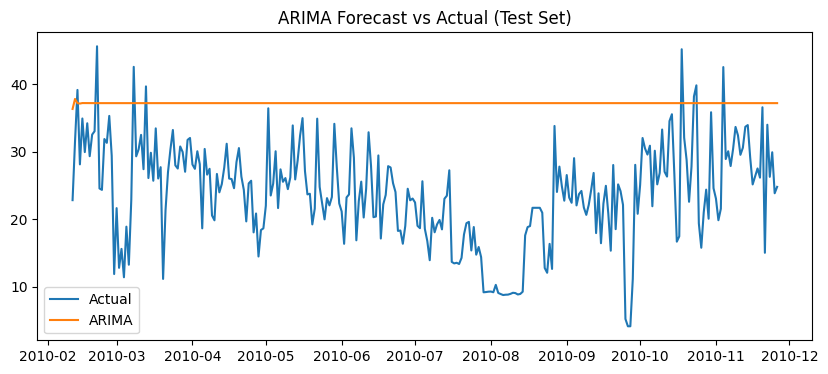

ARIMA RMSE: 15.44 kWh
ARIMA MAPE: 83.51%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [32]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(2, 1, 2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

rmse_arima = rmse(test.values, arima_forecast.values)
mape_arima = mape(test.values, arima_forecast.values)

plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, arima_forecast.values, label="ARIMA")
plt.legend()
plt.title("ARIMA Forecast vs Actual (Test Set)")
plt.show()

print(f"ARIMA RMSE: {rmse_arima:.2f} kWh")
print(f"ARIMA MAPE: {mape_arima:.2f}%")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

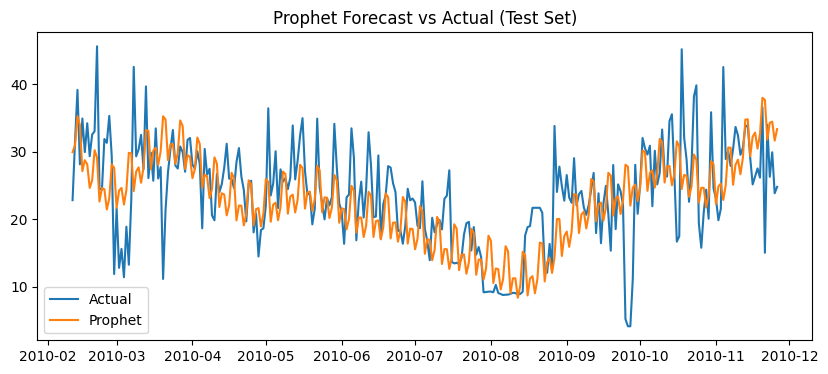

Prophet RMSE: 6.60 kWh
Prophet MAPE: 26.54%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [33]:
# Prophet -> κατάλληλο για trend + seasonality (weekly/yearly).
!pip -q install prophet

from prophet import Prophet

train_df = train.reset_index()
train_df.columns = ["ds", "y"]

prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
prophet.fit(train_df)

future = test.reset_index()[[test.index.name or "Datetime"]].copy()
future.columns = ["ds"]

prophet_fc = prophet.predict(future)
prophet_pred = prophet_fc["yhat"].values

rmse_prophet = rmse(test.values, prophet_pred)
mape_prophet = mape(test.values, prophet_pred)

plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, prophet_pred, label="Prophet")
plt.legend()
plt.title("Prophet Forecast vs Actual (Test Set)")
plt.show()

# Eμφάνιση Prophet RMSE & MAPE
print(f"Prophet RMSE: {rmse_prophet:.2f} kWh")
print(f"Prophet MAPE: {mape_prophet:.2f}%")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replac

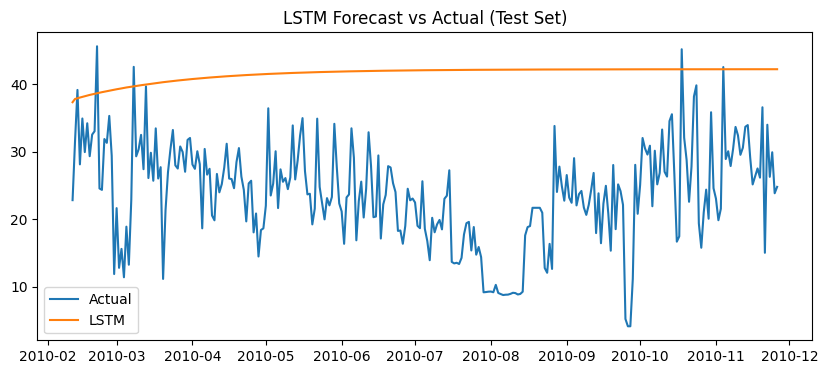

LSTM RMSE: 19.51 kWh
LSTM MAPE: 105.15%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [34]:
# LSTM

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Κάνουμε scaling ΜΟΝΟ στο train για αποφυγή leakage.
lookback = 30  # πόσες προηγούμενες μέρες βλέπει

# scaling μόνο στο train (χωρίς leakage)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

def make_sequences(arr_2d, lookback):
    X, y = [], []
    for i in range(lookback, len(arr_2d)):
        X.append(arr_2d[i-lookback:i, 0])
        y.append(arr_2d[i, 0])
    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)
    return X, y

X_train, y_train = make_sequences(train_scaled, lookback)

tf.random.set_seed(42)
lstm = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])
lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Recursive multi-step forecast στο test horizon
window = train_scaled[-lookback:].reshape(1, lookback, 1)
preds_scaled = []

for _ in range(len(test)):
    next_pred = lstm.predict(window, verbose=0)[0, 0]
    preds_scaled.append(next_pred)
    new_window = np.append(window[0, 1:, 0], next_pred)
    window = new_window.reshape(1, lookback, 1)

lstm_pred = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).ravel()

rmse_lstm = rmse(test.values, lstm_pred)
mape_lstm = mape(test.values, lstm_pred)

plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, lstm_pred, label="LSTM")
plt.legend()
plt.title("LSTM Forecast vs Actual (Test Set)")
plt.show()

#εμφάνιση LSTM RMSE & MAPE
print(f"LSTM RMSE: {rmse_lstm:.2f} kWh")
print(f"LSTM MAPE: {mape_lstm:.2f}%")


In [35]:
# Σύγκριση των 3 μοντέλων
results = pd.DataFrame({
    "Model": ["ARIMA(2,1,2)", "Prophet", "LSTM"],
    "RMSE":  [rmse_arima, rmse_prophet, rmse_lstm],
    "MAPE%": [mape_arima, mape_prophet, mape_lstm]
}).sort_values("RMSE")

display(results)

best_rmse = results.iloc[0]
print(f"Best by RMSE: {best_rmse['Model']} (RMSE={best_rmse['RMSE']:.2f}, MAPE={best_rmse['MAPE%']:.2f}%")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Model,RMSE,MAPE%
1,Prophet,6.595113,26.541062
0,"ARIMA(2,1,2)",15.442242,83.505033
2,LSTM,19.508587,105.146251


Best by RMSE: Prophet (RMSE=6.60, MAPE=26.54%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag